In [66]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO, BytesIO
import zipfile
import requests

In [67]:
#Download zip
r = requests.get("https://snap.stanford.edu/data/twitch_gamers.zip")
archive = zipfile.ZipFile(BytesIO(r.content), 'r')

In [68]:
#Load rawdata

twitch_rawdata_edges = StringIO(str(archive.read('large_twitch_edges.csv'), 'utf-8'))
twitch_rawdata_feature = StringIO(str(archive.read('large_twitch_features.csv'), 'utf-8'))

twitch_raw_data_df_feature = pd.read_csv(twitch_rawdata_feature, sep=",")
twitch_raw_data_df_edges = pd.read_csv(twitch_rawdata_edges, sep=",")

In [69]:
#Get only polish streamers

twitch_filter_PL = twitch_raw_data_df_feature["language"] == "PL"
twitch_df_feature = twitch_raw_data_df_feature[twitch_filter_PL]

twitch_filter_edges = twitch_raw_data_df_edges["numeric_id_1"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges2 = twitch_raw_data_df_edges["numeric_id_2"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges_pair = twitch_filter_edges & twitch_filter_edges2
twitch_df_edges = twitch_raw_data_df_edges[twitch_filter_edges_pair]

In [70]:
#Create graph

twitch_graph = nx.from_pandas_edgelist(twitch_df_edges, 'numeric_id_1', 'numeric_id_2')

for index, node in twitch_df_feature.iterrows():
    twitch_graph.add_node(node["numeric_id"], 
                          views=node["views"],
                          mature=node["mature"],
                          life_time=node["life_time"],
                          created_at=node["created_at"],
                          updated_at=node["updated_at"],
                          dead_account=node["dead_account"],
                          language=node["language"],
                          affiliate=node["affiliate"])

In [71]:
degree_sequence = sorted((d for n, d in twitch_graph.degree()), reverse=True)

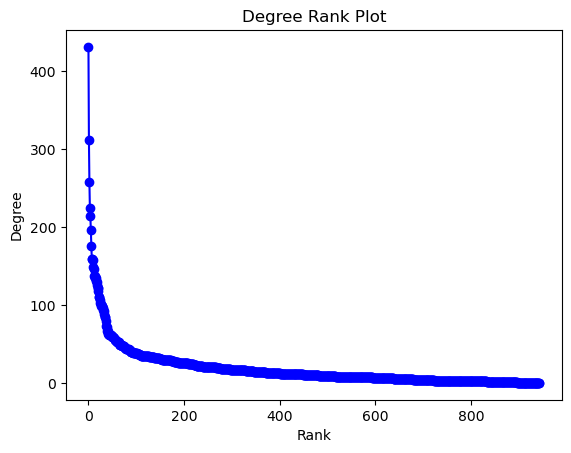

In [72]:
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank Plot")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.show()

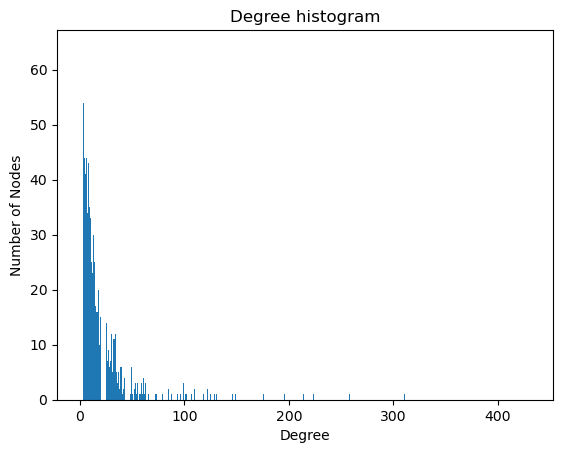

In [73]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

In [74]:
p = dict(nx.shortest_path_length(twitch_graph))

In [ ]:
bc = nx.betweenness_centrality(twitch_graph)